In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
df_all = pd.read_csv('concatenate_data.csv', thousands=',') # 콤마 제거

df_all['date'] = pd.to_datetime(df_all['date'], format='%m/%d/%Y')  # 날짜 형식 변환
df_all = df_all.sort_values(by = 'date', ascending=True)
df_all = df_all.iloc[-3568:]


X_lst = ['EUA', 'Coal', 'USEU', 'Oil', 'Market_Size', 'NG', 'IR', 'Power', 'GDP', 'S&P_clean', 'DAX']
df = df_all[X_lst]

original_EUA = df['EUA'].values  # 원본 EUA 데이터 저장
data = df.values[:, :11]  # ['EUA', 'Coal', 'USEU', 'Oil', 'Market_Size', 'NG', 'IR', 'Power', 'GDP', 'S&P_clean', 'DAX']
dates = df_all['date'].values

In [3]:
df_all.head()

,date,IR,Oil,Coal,NG,USEU,S&P_clean,DAX,EUA,Market_Size,Power,GDP,Date
3567,2015-01-01,0.05,57.33,66.70,21.296,0.8261,624.64,9805.55,7.25,0.0,32.1,2921043.3,2015-01-01
3566,2015-01-02,0.05,56.42,65.55,20.448,0.8332,626.91,9764.73,7.01,280.4,32.1,2921043.3,2015-01-02
3565,2015-01-03,0.05,56.42,65.55,20.448,0.8332,626.91,9764.73,7.01,280.4,32.1,2921043.3,2015-01-03
3564,2015-01-04,0.05,56.42,65.55,20.448,0.8332,626.91,9764.73,7.01,280.4,32.1,2921043.3,2015-01-04
3563,2015-01-05,0.05,53.11,63.65,20.145,0.8380,615.40,9473.16,6.90,621.0,32.1,2921043.3,2015-01-05


In [4]:
scaler = MinMaxScaler((-1, 1))
data_scaled = scaler.fit_transform(data)

In [5]:
# 입력 시퀀스의 길이
sequence_length = 20

# 테스트 데이터는 최신 날짜부터 sequence_length + 100만큼 사용
test_data_size = sequence_length + 1  # 테스트 데이터의 크기 설정 (예: sequence_length보다 100개 더 많게 설정)

# 데이터를 최신 데이터 기준으로 슬라이싱
test_data_scaled = data_scaled[-(test_data_size + 1):]  # 데이터의 마지막 부분을 테스트 데이터로 사용
test_dates = dates[-(test_data_size + 1):]

# 나머지를 학습 데이터로 설정 (앞부분을 학습 데이터로 사용)
train_data_scaled = data_scaled[:-(test_data_size + 1)]
train_dates = dates[:-(test_data_size + 1)]

In [6]:
# 학습 데이터셋을 시퀀스 형태로 만들기 위한 함수
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])  # seq_length 만큼의 입력 시퀀스
        y.append(data[i + seq_length])  # 모든 변수 예측
    return np.array(X), np.array(y)

In [7]:
# 학습 데이터로 시퀀스 생성
X_train, y_train = create_sequences(train_data_scaled, sequence_length)
# 테스트 데이터로 시퀀스 생성
X_test, y_test = create_sequences(test_data_scaled, sequence_length)

In [8]:
# LSTM 모델 구축
model = Sequential()

# 첫 번째 LSTM 레이어 + L2 정규화 + 배치 정규화
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]),  activation='tanh', recurrent_activation='sigmoid',
               return_sequences=True,
               kernel_regularizer=l2(0.001))) # L2 정규화 적용
model.add(BatchNormalization()) # 배치 정규화 추가
model.add(Dropout(0.3))

# 두 번째 LSTM 레이어 + L2 정규화 + 배치 정규화 (512 유닛)
model.add(LSTM(32, activation='tanh', recurrent_activation='sigmoid', return_sequences=True, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization()) # 배치 정규화
model.add(Dropout(0.3))

# 두 번째 LSTM 레이어 + L2 정규화 + 배치 정규화 (512 유닛)
model.add(LSTM(32, activation='tanh', recurrent_activation='sigmoid', return_sequences=False, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())

# Dense 레이어 (출력은 11개, 배열 순서대로)
model.add(Dense(11, activation='linear'))

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

c:\Users\kangs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# 모델 가중치 로드 시도 (존재하지 않으면 학습 시작)
# 모델 저장 경로 설정
checkpoint_path = "./FromParis2015/best_model_61.keras"
try:
    model.load_weights(checkpoint_path)  # load_weights로 변경
    print("모델 가중치를 성공적으로 로드했습니다.")
except:
    print("가중치를 찾을 수 없습니다. 모델을 처음부터 학습합니다.")

    # ModelCheckpoint 콜백 설정 (val_loss가 가장 낮을 때 모델 저장)
    checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                monitor='val_loss',  # val_loss를 기준으로 모니터링
                                save_best_only=True,  # 가장 좋은 모델만 저장
                                mode='min',  # val_loss가 작을수록 좋음
                                verbose=1)

    # EarlyStopping 콜백 설정 (val_loss가 patience번의 에포크 동안 개선되지 않으면 학습 중단)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

    # 모델 학습 (300 에포크, 배치 사이즈 15, 2% 검증 데이터 사용)
    history = model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_split=0.05,
                        verbose=1, callbacks=[checkpoint ,early_stopping]) #])  # early_stopping 추가

    # 학습이 멈춘 에포크 확인
    #if early_stopping.stopped_epoch > 0:
    #    print(f"Early stopping at epoch {early_stopping.stopped_epoch + 1}")  # 중단된 에포크 출력
    #else:
    #    print("Early stopping was not triggered.")


모델 가중치를 성공적으로 로드했습니다.


c:\Users\kangs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 36 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [10]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [11]:
train_predictions = model.predict(X_train)
train_predictions_rescaled = scaler.inverse_transform(train_predictions)

test_predictions = model.predict(X_test)
test_predictions_rescaled = scaler.inverse_transform(test_predictions)

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [12]:
num_of_prediction = 30*2
future_predictions = []

current_input = test_data_scaled[-sequence_length:, :]

for i in range(num_of_prediction):
# LSTM 모델에 맞게 3차원 입력으로 변환, (배치 크기, 시퀀스 길이, 변수 개수)
    current_input_scaled = np.reshape(current_input, (1, sequence_length, current_input.shape[1]))
    # 다음 시점 예측
    next_prediction = model.predict(current_input_scaled)

    # 예측된 모든 변수를 저장
    future_predictions.append(next_prediction[0])  # 11개 변수 예측 결과를 저장
    
    # 새로운 입력을 업데이트 (슬라이딩 윈도우 방식)
    current_input = np.concatenate([current_input[1:], [next_prediction[0]]], axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

In [13]:
# 각 예측 시 11개 변수를 모두 포함하고 있으므로, 동일한 스케일링 방법을 사용
future_predictions_original = scaler.inverse_transform(future_predictions)

# 미래 날짜 생성
future_dates = [pd.to_datetime(test_dates[-1]) + pd.DateOffset(days=i + 1) for i in range(num_of_prediction)]

C:\Users\kangs\AppData\Local\Temp\ipykernel_9092\2627061273.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "g." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(train_dates[-train_predictions_rescaled.shape[0]:], train_predictions_rescaled[:, 0], 'g.', marker='.', markersize=2, label='Train Predicted EUA Price')


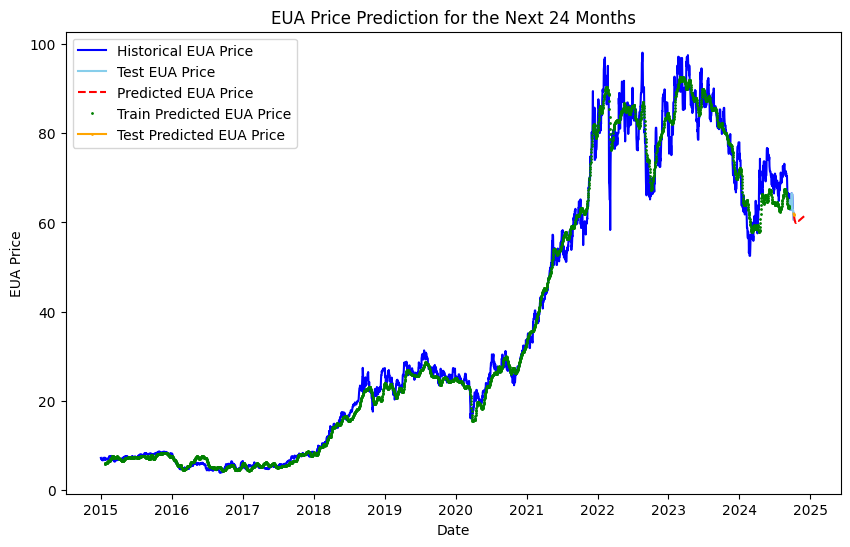

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(dates, original_EUA, 'b', label='Historical EUA Price')  # 원본 EUA 데이터
plt.plot(test_dates, scaler.inverse_transform(test_data_scaled)[:, 0], 'skyblue', label='Test EUA Price')  # 테스트 데이터
plt.plot(future_dates, future_predictions_original[:, 0], 'r--', label='Predicted EUA Price')

# 학습 데이터 예측값
plt.plot(train_dates[-train_predictions_rescaled.shape[0]:], train_predictions_rescaled[:, 0], 'g.', marker='.', markersize=2, label='Train Predicted EUA Price')
# 테스트 데이터 예측값
plt.plot(test_dates[-test_predictions_rescaled.shape[0]:], test_predictions_rescaled[:, 0], 'orange', marker='.', markersize=2, label='Test Predicted EUA Price')


plt.xlabel('Date')
plt.ylabel('EUA Price')
plt.title('EUA Price Prediction for the Next 24 Months')
plt.legend()
plt.show()